In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier # RandomForestClassifier
import datetime

In [3]:
%matplotlib inline
from sklearn.datasets import make_blobs

Step One

Importing Severe Weather Test Data

In [4]:
# importing test weather data
weather_df = pd.read_csv("SevereWeatherDetails_appended.csv", low_memory=False)

In [5]:
weather_df.head()

,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON
0,10096222,OKLAHOMA,40.0,1950,April,Tornado,0,0,0,0,250K,0,0.0,NaN,F3,3.4,400.0,35.12,-99.20
1,10120412,TEXAS,48.0,1950,April,Tornado,0,0,0,0,25K,0,0.0,NaN,F1,11.5,200.0,31.90,-98.60
2,10104927,PENNSYLVANIA,42.0,1950,July,Tornado,2,0,0,0,25K,0,0.0,NaN,F2,12.9,33.0,40.58,-75.70
3,10104928,PENNSYLVANIA,42.0,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,NaN,F2,0.0,13.0,40.60,-76.75
4,10104929,PENNSYLVANIA,42.0,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,NaN,F0,0.0,33.0,41.63,-79.68


In [6]:
# change month to a number count

weather_df['month'] = pd.to_datetime(weather_df.MONTH_NAME, format='%B').dt.month

In [7]:
# dropping columns not needed
weather_df = weather_df.drop(columns=['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
                                     'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE', 'TOR_LENGTH',
                                     'TOR_WIDTH', 'BEGIN_LAT', 'BEGIN_LON','CATEGORY', 'STATE', 'MONTH_NAME'])

In [8]:
weather_df.head()

,EVENT_ID,STATE_FIPS,YEAR,EVENT_TYPE,month
0,10096222,40.0,1950,Tornado,4
1,10120412,48.0,1950,Tornado,4
2,10104927,42.0,1950,Tornado,7
3,10104928,42.0,1950,Tornado,7
4,10104929,42.0,1950,Tornado,7


In [9]:
weather_df = weather_df.drop(weather_df[weather_df.YEAR > 2000].index)

In [10]:
# displaying weather df
weather_df.head()

,EVENT_ID,STATE_FIPS,YEAR,EVENT_TYPE,month
0,10096222,40.0,1950,Tornado,4
1,10120412,48.0,1950,Tornado,4
2,10104927,42.0,1950,Tornado,7
3,10104928,42.0,1950,Tornado,7
4,10104929,42.0,1950,Tornado,7


In [11]:
# adding together events by groups
group_groups = weather_df.groupby(['YEAR', "EVENT_TYPE", "STATE_FIPS"], as_index=False).count()
print(group_groups.head(10))
print(group_groups.tail(10))

   YEAR EVENT_TYPE  STATE_FIPS  EVENT_ID  month
0  1950    Tornado         1.0         2      2
1  1950    Tornado         5.0        13     13
2  1950    Tornado         8.0         3      3
3  1950    Tornado         9.0         2      2
4  1950    Tornado        12.0         6      6
5  1950    Tornado        13.0         4      4
6  1950    Tornado        17.0        11     11
7  1950    Tornado        18.0         3      3
8  1950    Tornado        19.0         4      4
9  1950    Tornado        20.0        33     33
      YEAR      EVENT_TYPE  STATE_FIPS  EVENT_ID  month
9766  2000  Winter Weather        34.0         6      6
9767  2000  Winter Weather        36.0        83     83
9768  2000  Winter Weather        37.0        56     56
9769  2000  Winter Weather        40.0        11     11
9770  2000  Winter Weather        42.0        10     10
9771  2000  Winter Weather        44.0         2      2
9772  2000  Winter Weather        45.0        31     31
9773  2000  Winter Weath

In [12]:
# rename 'EVENT_ID' column as 'Count' and 'YEAR' as 'Year'
group_groups = group_groups.rename(columns={'EVENT_ID': 'Count', 'YEAR': 'Year'})
group_groups.head()

,Year,EVENT_TYPE,STATE_FIPS,Count,month
0,1950,Tornado,1.0,2,2
1,1950,Tornado,5.0,13,13
2,1950,Tornado,8.0,3,3
3,1950,Tornado,9.0,2,2
4,1950,Tornado,12.0,6,6


In [13]:
# Co2 Below This

In [14]:
# importing test co2 data 
carbon_df = pd.read_csv("co2_byYear.csv", low_memory=False)

In [15]:
# display co2 data
carbon_df

,year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [16]:
# rename columns for merging purposes
carbon_df = carbon_df.rename(columns={"year": "Year"})
carbon_df

,Year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [17]:
# dropping columns not needed
carbon_df = carbon_df.drop(columns=['co2_per_unit_energy', 'coal_co2', 'cement_co2', 'flaring_co2', 'gas_co2',
                                         'oil_co2', 'other_industry_co2', 'ghg_per_capita', 'methane', 'methane_per_capita',
                                         'nitrous_oxide', 'nitrous_oxide_per_capita', 'population', 'gdp', 'primary_energy_consumption',
                                         'energy_per_capita', 'energy_per_gdp', 'total_ghg'])

In [18]:
# show new dataframe
carbon_df

,Year,co2,co2_per_capita
0,1950,23193.336,943.286
1,1951,24765.194,1214.978
2,1952,25203.424,834.737
3,1953,25929.893,880.578
4,1954,26744.552,1378.627
...,...,...,...
66,2016,124705.642,1156.831
67,2017,126304.716,1156.251
68,2018,128452.538,1152.783
69,2019,128422.887,1165.000


In [19]:
# Merge attempt one
combo_df = group_groups.merge(carbon_df, left_on='Year', right_on='Year')

In [20]:
# checking merge
combo_df

,Year,EVENT_TYPE,STATE_FIPS,Count,month,co2,co2_per_capita
0,1950,Tornado,1.0,2,2,23193.336,943.286
1,1950,Tornado,5.0,13,13,23193.336,943.286
2,1950,Tornado,8.0,3,3,23193.336,943.286
3,1950,Tornado,9.0,2,2,23193.336,943.286
4,1950,Tornado,12.0,6,6,23193.336,943.286
...,...,...,...,...,...,...,...
9771,2000,Winter Weather,44.0,2,2,92998.026,1174.210
9772,2000,Winter Weather,45.0,31,31,92998.026,1174.210
9773,2000,Winter Weather,50.0,113,113,92998.026,1174.210
9774,2000,Winter Weather,51.0,49,49,92998.026,1174.210


In [21]:
combo_df.EVENT_TYPE.unique()

array(['Tornado', 'Hail', 'Thunderstorm Wind',
       'TORNADOES, TSTM WIND, HAIL', 'HAIL/ICY ROADS',
       'THUNDERSTORM WINDS/FLOODING', 'HAIL FLOODING',
       'THUNDERSTORM WIND/ TREE', 'THUNDERSTORM WIND/ TREES',
       'THUNDERSTORM WINDS FUNNEL CLOU', 'THUNDERSTORM WINDS HEAVY RAIN',
       'THUNDERSTORM WINDS LIGHTNING', 'THUNDERSTORM WINDS/ FLOOD',
       'THUNDERSTORM WINDS/FLASH FLOOD', 'THUNDERSTORM WINDS/HEAVY RAIN',
       'TORNADO/WATERSPOUT', 'Avalanche', 'Blizzard', 'Coastal Flood',
       'Cold/Wind Chill', 'Debris Flow', 'Dense Fog', 'Drought',
       'Dust Devil', 'Dust Storm', 'Flash Flood', 'Flood', 'Freezing Fog',
       'Frost/Freeze', 'Funnel Cloud', 'Heat', 'Heavy Rain', 'Heavy Snow',
       'High Surf', 'High Wind', 'Hurricane (Typhoon)', 'Ice Storm',
       'Lightning', 'Marine High Wind', 'Rip Current', 'Storm Surge/Tide',
       'Strong Wind', 'Tropical Storm', 'Waterspout', 'Wildfire',
       'Winter Storm', 'Winter Weather', 'Astronomical Low Tide',
   

In [22]:
combo_df.loc[(combo_df.EVENT_TYPE == 'Tornado'),'EVENT_TYPE']=1
combo_df.loc[(combo_df.EVENT_TYPE == 'Hail'),'EVENT_TYPE']=2
combo_df.loc[(combo_df.EVENT_TYPE == 'Thunderstorm Wind'),'EVENT_TYPE']=3
combo_df.loc[(combo_df.EVENT_TYPE == 'TORNADOES, TSTM WIND, HAIL'),'EVENT_TYPE']=4
combo_df.loc[(combo_df.EVENT_TYPE == 'TSTM WIND'),'EVENT_TYPE']=5
combo_df.loc[(combo_df.EVENT_TYPE == 'HAIL'),'EVENT_TYPE']=6
combo_df.loc[(combo_df.EVENT_TYPE == 'HAIL/ICY ROADS'),'EVENT_TYPE']=7
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS/FLOODING'),'EVENT_TYPE']=8
combo_df.loc[(combo_df.EVENT_TYPE == 'HAIL FLOODING'),'EVENT_TYPE']=9
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WIND/ TREE'),'EVENT_TYPE']=10
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WIND/ TREES'),'EVENT_TYPE']=11
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS FUNNEL CLOU'),'EVENT_TYPE']=12
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS HEAVY RAIN'),'EVENT_TYPE']=13
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS LIGHTNING'),'EVENT_TYPE']=14
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS/ FLOOD'),'EVENT_TYPE']=15
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS/FLASH FLOOD'),'EVENT_TYPE']=16
combo_df.loc[(combo_df.EVENT_TYPE == 'THUNDERSTORM WINDS/HEAVY RAIN'),'EVENT_TYPE']=17
combo_df.loc[(combo_df.EVENT_TYPE == 'TORNADO/WATERSPOUT'),'EVENT_TYPE']=18
combo_df.loc[(combo_df.EVENT_TYPE == 'Avalanche'),'EVENT_TYPE']=19
combo_df.loc[(combo_df.EVENT_TYPE == 'Blizzard'),'EVENT_TYPE']=20
combo_df.loc[(combo_df.EVENT_TYPE == 'Coastal Flood'),'EVENT_TYPE']=21
combo_df.loc[(combo_df.EVENT_TYPE == 'Cold/Wind Chill'),'EVENT_TYPE']=22
combo_df.loc[(combo_df.EVENT_TYPE == 'Debris Flow'),'EVENT_TYPE']=23
combo_df.loc[(combo_df.EVENT_TYPE == 'Dense Fog'),'EVENT_TYPE']=24
combo_df.loc[(combo_df.EVENT_TYPE == 'Drought'),'EVENT_TYPE']=25
combo_df.loc[(combo_df.EVENT_TYPE == 'Dust Devil'),'EVENT_TYPE']=26
combo_df.loc[(combo_df.EVENT_TYPE == 'Dust Storm'),'EVENT_TYPE']=27
combo_df.loc[(combo_df.EVENT_TYPE == 'Flash Flood'),'EVENT_TYPE']=28
combo_df.loc[(combo_df.EVENT_TYPE == 'Flood'),'EVENT_TYPE']=29
combo_df.loc[(combo_df.EVENT_TYPE == 'Freezing Fog'),'EVENT_TYPE']=30
combo_df.loc[(combo_df.EVENT_TYPE == 'Frost/Freeze'),'EVENT_TYPE']=31
combo_df.loc[(combo_df.EVENT_TYPE == 'Funnel Cloud'),'EVENT_TYPE']=32
combo_df.loc[(combo_df.EVENT_TYPE == 'Heat'),'EVENT_TYPE']=33
combo_df.loc[(combo_df.EVENT_TYPE == 'Heavy Rain'),'EVENT_TYPE']=34
combo_df.loc[(combo_df.EVENT_TYPE == 'Heavy Snow'),'EVENT_TYPE']=35
combo_df.loc[(combo_df.EVENT_TYPE == 'High Surf'),'EVENT_TYPE']=36
combo_df.loc[(combo_df.EVENT_TYPE == 'High Wind'),'EVENT_TYPE']=37
combo_df.loc[(combo_df.EVENT_TYPE == 'Hurricane (Typhoon)'),'EVENT_TYPE']=38
combo_df.loc[(combo_df.EVENT_TYPE == 'Ice Storm'),'EVENT_TYPE']=39
combo_df.loc[(combo_df.EVENT_TYPE == 'Lightning'),'EVENT_TYPE']=40
combo_df.loc[(combo_df.EVENT_TYPE == 'Marine High Wind'),'EVENT_TYPE']=41
combo_df.loc[(combo_df.EVENT_TYPE == 'Rip Current'),'EVENT_TYPE']=42
combo_df.loc[(combo_df.EVENT_TYPE == 'Storm Surge/Tide'),'EVENT_TYPE']=43
combo_df.loc[(combo_df.EVENT_TYPE == 'Strong Wind'),'EVENT_TYPE']=44
combo_df.loc[(combo_df.EVENT_TYPE == 'Tropical Storm'),'EVENT_TYPE']=45
combo_df.loc[(combo_df.EVENT_TYPE == 'Waterspout'),'EVENT_TYPE']=46
combo_df.loc[(combo_df.EVENT_TYPE == 'Wildfire'),'EVENT_TYPE']=47
combo_df.loc[(combo_df.EVENT_TYPE == 'Winter Storm'),'EVENT_TYPE']=48
combo_df.loc[(combo_df.EVENT_TYPE == 'Winter Weather'),'EVENT_TYPE']=49
combo_df.loc[(combo_df.EVENT_TYPE == 'Astronomical Low Tide'),'EVENT_TYPE']=50
combo_df.loc[(combo_df.EVENT_TYPE == 'Lake-Effect Snow'),'EVENT_TYPE']=51
combo_df.loc[(combo_df.EVENT_TYPE == 'Sleet'),'EVENT_TYPE']=52
combo_df.loc[(combo_df.EVENT_TYPE == 'Volcanic Ash'),'EVENT_TYPE']=53
combo_df.loc[(combo_df.EVENT_TYPE == 'Seiche'),'EVENT_TYPE']=54
combo_df.loc[(combo_df.EVENT_TYPE == 'Excessive Heat'),'EVENT_TYPE']=55
combo_df.loc[(combo_df.EVENT_TYPE == 'Extreme Cold/Wind Chill'),'EVENT_TYPE']=56
combo_df.head(20)

,Year,EVENT_TYPE,STATE_FIPS,Count,month,co2,co2_per_capita
0,1950,1,1.0,2,2,23193.336,943.286
1,1950,1,5.0,13,13,23193.336,943.286
2,1950,1,8.0,3,3,23193.336,943.286
3,1950,1,9.0,2,2,23193.336,943.286
4,1950,1,12.0,6,6,23193.336,943.286
5,1950,1,13.0,4,4,23193.336,943.286
6,1950,1,17.0,11,11,23193.336,943.286
7,1950,1,18.0,3,3,23193.336,943.286
8,1950,1,19.0,4,4,23193.336,943.286
9,1950,1,20.0,33,33,23193.336,943.286


In [23]:
combo_df.tail(20)

,Year,EVENT_TYPE,STATE_FIPS,Count,month,co2,co2_per_capita
9756,2000,49,13.0,25,25,92998.026,1174.21
9757,2000,49,17.0,27,27,92998.026,1174.21
9758,2000,49,18.0,6,6,92998.026,1174.21
9759,2000,49,19.0,12,12,92998.026,1174.21
9760,2000,49,21.0,2,2,92998.026,1174.21
9761,2000,49,23.0,31,31,92998.026,1174.21
9762,2000,49,24.0,24,24,92998.026,1174.21
9763,2000,49,25.0,13,13,92998.026,1174.21
9764,2000,49,29.0,21,21,92998.026,1174.21
9765,2000,49,33.0,24,24,92998.026,1174.21


# Random Forest Regressor

In [24]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(combo_df['EVENT_TYPE'])
# Remove the labels from the features
# axis 1 refers to the columns
features= combo_df.drop('EVENT_TYPE', axis = 1)
# Saving feature names for later use
feature_list = list(combo_df.columns)
# Convert to numpy array
features = np.array(combo_df)

In [25]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [26]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7332, 7)
Training Labels Shape: (7332,)
Testing Features Shape: (2444, 7)
Testing Labels Shape: (2444,)


In [27]:
# convert Event Type to integers
combo_df['EVENT_TYPE'] = combo_df['EVENT_TYPE'].astype(int)

In [28]:
# check conversion 
combo_df.dtypes

Year                int64
EVENT_TYPE          int64
STATE_FIPS        float64
Count               int64
month               int64
co2               float64
co2_per_capita    float64
dtype: object

In [29]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('EVENT_TYPE')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.0


In [30]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [31]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Number of Events:', round(np.mean(errors), 2), 'Events')

Mean Number of Events: 0.0 Events


In [32]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.99 %.


### Testing other Machine Learning Algorithms 

In [38]:
# select only from years 1950 to 2000
combo_df = combo_df.drop(combo_df[combo_df.Year > 2000].index)

In [40]:
# check new code
combo_df

,Year,EVENT_TYPE,STATE_FIPS,Count,month,co2,co2_per_capita
0,1950,1,1.0,2,2,23193.336,943.286
1,1950,1,5.0,13,13,23193.336,943.286
2,1950,1,8.0,3,3,23193.336,943.286
3,1950,1,9.0,2,2,23193.336,943.286
4,1950,1,12.0,6,6,23193.336,943.286
...,...,...,...,...,...,...,...
9771,2000,49,44.0,2,2,92998.026,1174.210
9772,2000,49,45.0,31,31,92998.026,1174.210
9773,2000,49,50.0,113,113,92998.026,1174.210
9774,2000,49,51.0,49,49,92998.026,1174.210


In [41]:
# Print out the # of yearly events value counts
count_counts = combo_df.Count.value_counts()
count_counts

1       887
2       629
3       489
4       402
5       337
       ... 
715       1
747       1
795       1
803       1
1735      1
Name: Count, Length: 481, dtype: int64

In [42]:
count_counts.head

<bound method NDFrame.head of 1       887
2       629
3       489
4       402
5       337
       ... 
715       1
747       1
795       1
803       1
1735      1
Name: Count, Length: 481, dtype: int64>

<AxesSubplot:ylabel='Density'>

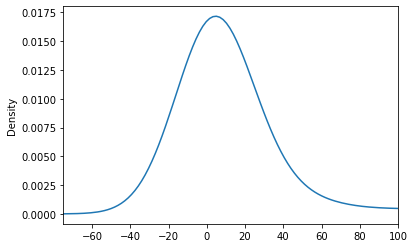

In [43]:
# Visualize the value counts
count_counts.plot.density(xlim=(-75,100))

In [44]:
# Determine which values to replace
replace_counts = list(count_counts[count_counts < 2].index)
# remove values that occur less than 3 times
combo_df = combo_df[~combo_df['Count'].isin(replace_counts)]
# Check to make sure binning was successful
combo_df.Count.value_counts()

1      887
2      629
3      489
4      402
5      337
      ... 
510      2
662      2
425      2
401      2
535      2
Name: Count, Length: 305, dtype: int64

### Targets and Data Splitting

In [45]:
# create the target
target = ["Count"]

In [46]:
# split data into training and testing

X = combo_df.drop(columns=["Count", "co2_per_capita", "EVENT_TYPE", "STATE_FIPS", "month" ])

# Create our target
y = combo_df["Count"]

In [49]:
from pandas import Series
from numpy.random import randn

In [50]:
y.describe()

count    9600.000000
mean       39.144583
std        63.776951
min         1.000000
25%         4.000000
50%        15.000000
75%        45.000000
max      1028.000000
Name: Count, dtype: float64

In [51]:
# Check the balance of our target values
y = combo_df['Count']
y.value_counts()

1      887
2      629
3      489
4      402
5      337
      ... 
510      2
662      2
425      2
401      2
535      2
Name: Count, Length: 305, dtype: int64

# BalancedRandomForestClassifier

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({24: 81,
         2: 472,
         5: 253,
         6: 224,
         1: 665,
         17: 121,
         26: 76,
         4: 301,
         7: 180,
         13: 124,
         38: 37,
         8: 181,
         9: 173,
         63: 22,
         42: 35,
         32: 59,
         21: 89,
         20: 84,
         10: 159,
         83: 15,
         34: 45,
         28: 46,
         48: 34,
         59: 22,
         47: 29,
         12: 148,
         23: 78,
         31: 51,
         46: 34,
         44: 29,
         19: 98,
         33: 55,
         128: 11,
         71: 20,
         3: 367,
         15: 95,
         27: 53,
         25: 72,
         74: 11,
         11: 155,
         110: 10,
         16: 116,
         14: 119,
         18: 82,
         51: 29,
         116: 6,
         93: 12,
         36: 47,
         108: 10,
         80: 15,
         222: 4,
         22: 78,
         52: 29,
         40: 38,
         85: 15,
         53: 30,
         160: 4,
         50: 35,
    

In [53]:
# resample the training data with the BalancedRandomForestClassifier

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brfc.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [54]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = brfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
# calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.003703703703703704

In [56]:
# print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00       222
          2       0.00      0.00      1.00      0.00      0.00      0.00       157
          3       0.00      0.00      1.00      0.00      0.00      0.00       122
          4       0.00      0.00      1.00      0.00      0.00      0.00       101
          5       0.00      0.00      1.00      0.00      0.00      0.00        84
          6       0.00      0.00      1.00      0.00      0.00      0.00        74
          7       0.00      0.00      1.00      0.00      0.00      0.00        60
          8       0.00      0.00      1.00      0.00      0.00      0.00        60
          9       0.00      0.00      1.00      0.00      0.00      0.00        58
         10       0.00      0.00      1.00      0.00      0.00      0.00        53
         11       0.00      0.00      1.00      0.00      0.00      0.00        52
   

In [58]:
# list the features sorted in descending order by feature importance
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)

[(0.5211761979085141, 'co2'), (0.47882380209148595, 'Year')]

# Easy Ensemble AdaBoost Classifier

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({24: 81,
         2: 472,
         5: 253,
         6: 224,
         1: 665,
         17: 121,
         26: 76,
         4: 301,
         7: 180,
         13: 124,
         38: 37,
         8: 181,
         9: 173,
         63: 22,
         42: 35,
         32: 59,
         21: 89,
         20: 84,
         10: 159,
         83: 15,
         34: 45,
         28: 46,
         48: 34,
         59: 22,
         47: 29,
         12: 148,
         23: 78,
         31: 51,
         46: 34,
         44: 29,
         19: 98,
         33: 55,
         128: 11,
         71: 20,
         3: 367,
         15: 95,
         27: 53,
         25: 72,
         74: 11,
         11: 155,
         110: 10,
         16: 116,
         14: 119,
         18: 82,
         51: 29,
         116: 6,
         93: 12,
         36: 47,
         108: 10,
         80: 15,
         222: 4,
         22: 78,
         52: 29,
         40: 38,
         85: 15,
         53: 30,
         160: 4,
         50: 35,
    

In [60]:
# Train the EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

X, y = load_iris(return_X_y=True)
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
scores = cross_val_score(eec, X, y, cv=5)
scores.mean()

0.9466666666666667

In [61]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [62]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = eec.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [63]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.0038461538461538464

In [64]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00       222
          2       0.00      0.00      1.00      0.00      0.00      0.00       157
          3       0.00      0.00      1.00      0.00      0.00      0.00       122
          4       0.00      0.00      1.00      0.00      0.00      0.00       101
          5       0.00      0.00      1.00      0.00      0.00      0.00        84
          6       0.00      0.00      1.00      0.00      0.00      0.00        74
          7       0.00      0.00      1.00      0.00      0.00      0.00        60
          8       0.00      0.00      1.00      0.00      0.00      0.00        60
          9       0.00      0.00      1.00      0.00      0.00      0.00        58
         10       0.00      0.00      1.00      0.00      0.00      0.00        53
         11       0.04      0.04      0.98      0.04      0.19      0.03        52
   